In [1]:

####################################################################################################
####################################################################################################

import sys
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

import keras
from keras import backend as K
from keras import layers
from keras.layers import Dense
from keras.models import load_model
from keras.models import Sequential
import keras.utils.vis_utils
from keras.utils import plot_model

sys.path.append(os.path.abspath("../python_pax_reader"))
import waveformset as wfset

from helpers import *

plt.style.use('dbarge')


Using TensorFlow backend.


In [2]:

####################################################################################################
####################################################################################################

file_raw   = "../data_xenon_waveform/FakeWaveform_raw/XENON1T-0-000000000-000000999-000001000.zip"
file_truth = "../data_xenon_waveform/FakeWaveform_truth.csv"



In [3]:

####################################################################################################
####################################################################################################

nEventsGeant = 2

wfs = wfset.WaveformSet()

wfs.read_data_and_truth(file_raw, file_truth, nEventsGeant)



100%|██████████| 1000/1000 [00:02<00:00, 335.71it/s]


Events:    2
PMT Shape: (248,)


In [4]:

##########################################################################################
##########################################################################################

nEvent = 1

df_pmts = wfs.get_waveforms_in_channels(nEvent)
df_pmts = df_pmts.iloc[:, 0:127]



In [5]:

##########################################################################################
# True Time Window of S2 Pulse
##########################################################################################

df_truth = wfs.truth()[nEvent]
df_truth = df_truth.loc[df_truth['peak_type'] == 's2']

t0 = df_truth.iloc[0]['t_first_electron']
t1 = df_truth.iloc[0]['t_last_electron']

s0 = int(np.round(t0 / 10))
s1 = int(np.round(t1 / 10))

eps = (s1 - s0)*2.0
x0  = s0 - eps
x1  = s1 + eps



In [22]:

##########################################################################################
##########################################################################################

df_pmts_s2ranked    = waveformIndexRankedByIntegral(df_pmts, s0, s1)
   
idxs_pmts_top127    = df_pmts_s2ranked.iloc[0:127, 0:1].as_matrix().reshape(127)
idxs_pmts_top065    = df_pmts_s2ranked.iloc[0: 65, 0:1].as_matrix().reshape(65)
idxs_pmts_top050    = df_pmts_s2ranked.iloc[0: 50, 0:1].as_matrix().reshape(50)
idxs_pmts_top030    = df_pmts_s2ranked.iloc[0: 30, 0:1].as_matrix().reshape(30)
idxs_pmts_top020    = df_pmts_s2ranked.iloc[0: 20, 0:1].as_matrix().reshape(20)
idxs_pmts_top010    = df_pmts_s2ranked.iloc[0: 10, 0:1].as_matrix().reshape(10)

arr_waveform_sum127 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top127, s0, s1)
arr_waveform_sum065 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top065, s0, s1)
arr_waveform_sum050 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top050, s0, s1)
arr_waveform_sum030 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top030, s0, s1)
arr_waveform_sum020 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top020, s0, s1)
arr_waveform_sum010 = sumWaveformsOverPMTs(df_pmts, idxs_pmts_top020, s0, s1)

sum_s2_all = np.sum(arr_waveform_sum127[s0:s1])

nSamples = len(arr_waveform_sum127)

arr_waveform_sum127_norm = np.divide(arr_waveform_sum127, sum_s2_all*np.ones(nSamples)) 
arr_waveform_sum065_norm = np.divide(arr_waveform_sum065, sum_s2_all*np.ones(nSamples))
arr_waveform_sum050_norm = np.divide(arr_waveform_sum050, sum_s2_all*np.ones(nSamples))
arr_waveform_sum030_norm = np.divide(arr_waveform_sum030, sum_s2_all*np.ones(nSamples))
arr_waveform_sum020_norm = np.divide(arr_waveform_sum020, sum_s2_all*np.ones(nSamples))
arr_waveform_sum010_norm = np.divide(arr_waveform_sum010, sum_s2_all*np.ones(nSamples))

if (np.sum(arr_waveform_sum127_norm[s0:s1]) != 1):
    
    print("Error in Normalizatoin!")



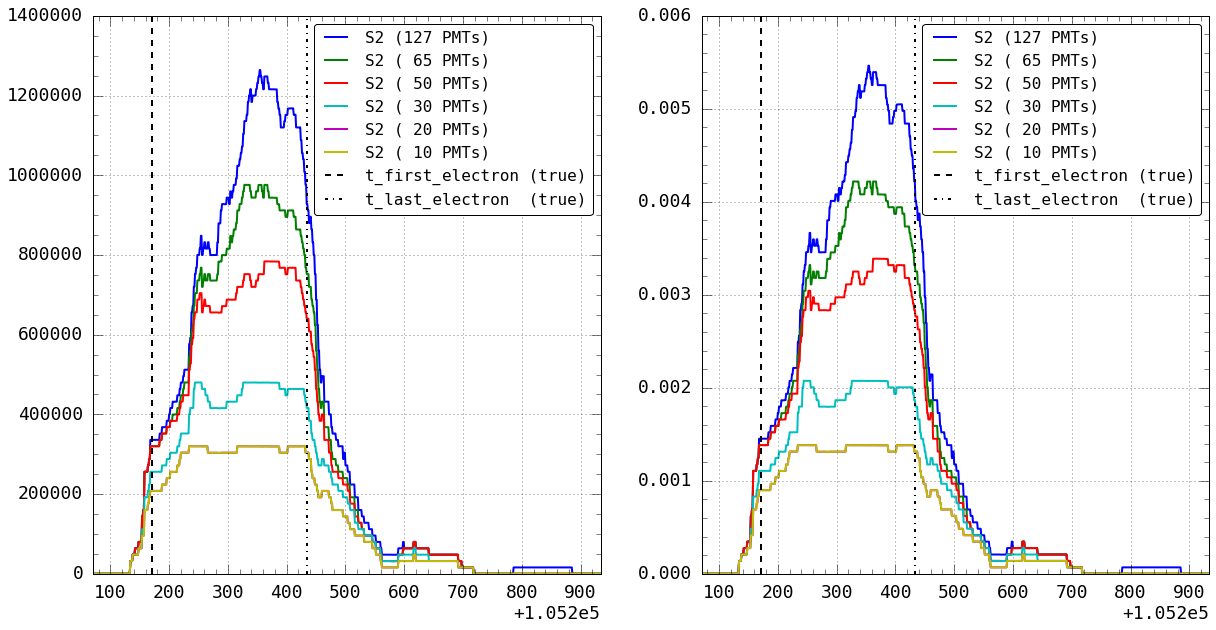

In [23]:

##########################################################################################
##########################################################################################

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax1 = plt.subplot(1, 2, 1)
plt.plot(arr_waveform_sum127, label='S2 (127 PMTs)')
plt.plot(arr_waveform_sum065, label='S2 ( 65 PMTs)')
plt.plot(arr_waveform_sum050, label='S2 ( 50 PMTs)')
plt.plot(arr_waveform_sum030, label='S2 ( 30 PMTs)')
plt.plot(arr_waveform_sum020, label='S2 ( 20 PMTs)')
plt.plot(arr_waveform_sum010, label='S2 ( 10 PMTs)')
plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_electron (true)')
plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_electron  (true)')
plt.xlim([s0-100, s1+500])
plt.legend(fontsize=16)

#
ax2 = plt.subplot(1, 2, 2)
plt.plot(arr_waveform_sum127_norm, label='S2 (127 PMTs)')
plt.plot(arr_waveform_sum065_norm, label='S2 ( 65 PMTs)')
plt.plot(arr_waveform_sum050_norm, label='S2 ( 50 PMTs)')
plt.plot(arr_waveform_sum030_norm, label='S2 ( 30 PMTs)')
plt.plot(arr_waveform_sum020_norm, label='S2 ( 20 PMTs)')
plt.plot(arr_waveform_sum010_norm, label='S2 ( 10 PMTs)')
plt.axvline(x=s0, color='k', linestyle='dashed' , label='t_first_electron (true)')
plt.axvline(x=s1, color='k', linestyle='dashdot', label='t_last_electron  (true)')
plt.xlim([s0-100, s1+500])
plt.legend(fontsize=16)

f.savefig("plots/s2_summed_frac.png")
plt.close()

print()
display(f)
print()



In [ ]:

sum_s2_all = 1

##########################################################################################
# Plot the S2 contribution per PMT
##########################################################################################

arr_s2_idx   = df_pmts_s2ranked.iloc[:, 0].as_matrix()
arr_s2_sum   = df_pmts_s2ranked.iloc[:, 1].as_matrix()
arr_s2_sum   = arr_s2_sum.reshape(arr_s2_sum.size, 1)

arr_s2_denom = sum_s2_all*np.ones(arr_s2_sum.size).reshape(arr_s2_sum.size, 1)
arr_s2_frac  = np.divide(arr_s2_sum, arr_s2_denom)

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.7)

ax1 = plt.subplot(2, 1, 1)
plt.plot(arr_s2_sum)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral')
plt.title('S2 Integral vs. PMT', y=1.05)

ax2 = plt.subplot(2, 1, 2)
plt.plot(arr_s2_frac)
plt.xlim([0, 127])
plt.xlabel('PMT index in order of descending S2 fraction')
plt.ylabel('S2 Integral Fraction')
plt.title('S2 Integral Fraction vs. PMT', y=1.05)

f.savefig("plots/s2_integral_vs_pmt.png")

plt.close()

print()
display(f)
print()


In [ ]:

##########################################################################################
# Facet Grid
##########################################################################################

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row="g", hue="g", aspect=15, size=.5, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color, 
            ha="left", va="center", transform=ax.transAxes)

g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play will with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [ ]:

##########################################################################################
# Sanity
##########################################################################################

sum_waveforms = wfs.waveforms_in_channels[nEvent].drop("event_number", axis=1).iloc[:, 0:127].sum(axis=1).as_matrix()

sum_s2_all = np.sum(sum_waveforms[s0:s1])

plt.plot(sum_waveforms, color='b')
plt.plot(x_127        , color='y')

plt.xlim([s0-100, s1+500])